In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from constants import SHARED_RANDOM_STATE
from db_helper_functions import get_stock_news_with_bertopic_sentiment_scores_from_db
from grid_model_search_functions import (
    grid_cv_test_model,
    iterative_grid_cv_model_testing,
)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import ParameterGrid
from supervised_learning_data_preprocessing_functions import (
    gen_df_for_supervised_learning,
)

ticker = "AAPL"

/var/folders/0r/w8vqcgg56n9113ksf0mt1n940000gn/T/ipykernel_9991/2965792065.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
bert_topic_article_sentiment_df = gen_df_for_supervised_learning(
    ticker=ticker,
    sentiment_df_retrieval_function=get_stock_news_with_bertopic_sentiment_scores_from_db,
)

dataframes_to_test = [
    (bert_topic_article_sentiment_df, "bert_topic_article_sentiment_df"),
]

cv_train_size = [126]
cv_test_size = [31]
lag_time = [5]
tss_splits = 5
features_to_use = [
    "open",
    "prev_high",
    "prev_low",
    "prev_close",
    "positive",
    "negative",
    "neutral",
]


feature_to_predict = ["closed_higher"]
scoring_method = ["accuracy"]

param_grid = {
    "data_frame": dataframes_to_test,
    "cv_train_size": cv_train_size,
    "cv_test_size": cv_test_size,
    "lag_time": lag_time,
    "feature_to_predict": feature_to_predict,
    "scoring_method": scoring_method,
}
data_settings_grid_list = list(ParameterGrid(param_grid))

/Users/raulmartinez/Desktop/MADS/Milestone_2/w24-milestone2-team18-leevw-steveso-raulmart/.venv/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [3]:
gb_clf_results = iterative_grid_cv_model_testing(
    model=GradientBoostingClassifier(),
    model_parameters={
        "random_state": [SHARED_RANDOM_STATE],
        "learning_rate": [0.1, 0.2, 0.3, 0.4],
        "n_estimators": [5, 10, 20, 100],
        "max_depth": [None, 2, 5, 10, 15, 20],
        "max_leaf_nodes": [None, 2, 5, 10, 15, 20],
    },
    data_settings_grid_list=data_settings_grid_list,
    features_to_use=features_to_use,
    tss_splits=tss_splits,
)

In [4]:
gb_clf_results = gb_clf_results.sort_values(
    ["mean_test_score", "std_test_score"], ascending=[False, True]
)

In [5]:
gbc = GradientBoostingClassifier()
params = {k[7:]: [v] for k, v in gb_clf_results.iloc[0].params.items()}

features_to_use = [
    "open",
    "prev_high",
    "prev_low",
    "prev_close",
    "positive",
    "negative",
    "neutral",
]

best_model = grid_cv_test_model(
    model=gbc,
    model_parameters=params,
    data_frame=bert_topic_article_sentiment_df,
    features_to_use=features_to_use,
    feature_to_predict=feature_to_predict[0],
    scoring_method=scoring_method[0],
    cv_train_size=cv_train_size[0],
    cv_test_size=cv_test_size[0],
    lag_time=lag_time[0],
    num_tss_splits=tss_splits,
    return_model=True,
)

### Feature Importance Analysis


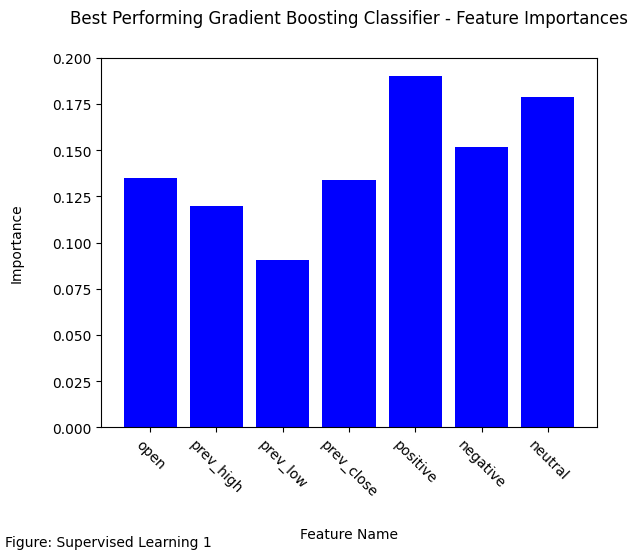

[('open', 0.1349021915368097), ('prev_high', 0.11972562623022805), ('prev_low', 0.09059025751128989), ('prev_close', 0.1336989832511357), ('positive', 0.19020075386067248), ('negative', 0.15191971746674438), ('neutral', 0.1789624701431198)]


In [6]:
features_and_importances = list(
    zip(
        best_model.best_estimator_[0].feature_names_in_,
        best_model.best_estimator_[1].feature_importances_,
    )
)

plt.figure()
plt.bar(
    best_model.best_estimator_[0].feature_names_in_,
    best_model.best_estimator_[1].feature_importances_,
    color="b",
)

plt.title("Best Performing Gradient Boosting Classifier - Feature Importances", pad=25)
plt.xlabel("Feature Name", labelpad=20)
plt.tick_params(axis="x", rotation=-45)

plt.ylabel("Importance", labelpad=20)
plt.ylim((0, 0.20))
plt.annotate("Figure: Supervised Learning 1", xy=(5, 5), xycoords="figure pixels")
plt.show()
print(features_and_importances)

### Feature Ablation Analysis


In [7]:
all_features = [
    "open",
    "prev_high",
    "prev_low",
    "prev_close",
    "positive",
    "negative",
    "neutral",
]

only_stock_data = [
    "open",
    "prev_high",
    "prev_low",
    "prev_close",
]

only_sentiment_data = [
    "positive",
    "negative",
    "neutral",
]


polarizing = [
    "open",
    "positive",
    "negative",
]

removing_lowest = [
    "open",
    "prev_high",
    "prev_close",
    "positive",
    "negative",
    "neutral",
]


for feats in [
    (all_features, "all_features"),
    (only_sentiment_data, "only_sentiment_data"),
    (only_stock_data, "only_stock_data"),
    (polarizing, "polarizing"),
    (removing_lowest, "removing_lowest"),
]:
    gbc = GradientBoostingClassifier()
    params = {k[7:]: [v] for k, v in gb_clf_results.iloc[0].params.items()}

    best_model = grid_cv_test_model(
        model=gbc,
        model_parameters=params,
        data_frame=bert_topic_article_sentiment_df,
        features_to_use=feats[0],
        feature_to_predict=feature_to_predict[0],
        scoring_method=scoring_method[0],
        cv_train_size=cv_train_size[0],
        cv_test_size=cv_test_size[0],
        lag_time=lag_time[0],
        num_tss_splits=tss_splits,
    )

    df = pd.DataFrame(best_model).sort_values("mean_test_score", ascending=False)
    print(feats[1])
    print(round(df.iloc[0].mean_test_score, 5))
    print(round(df.iloc[0].std_test_score, 5))
    print("########")

all_features
0.62581
0.12675
########
only_sentiment_data
0.47097
0.05624
########
only_stock_data
0.54839
0.10201
########
polarizing
0.57419
0.10872
########
removing_lowest
0.58065
0.07356
########
